[The 1st IAA-CSIC Severo Ochoa School on Statistics, Data Mining and Machine Learning](https://www.granadacongresos.com/sostat)


[Zeljko Ivezic, University of Washington](http://faculty.washington.edu/ivezic/) 

[This notebook](https://github.com/carmensg/IAA_School2019/tree/master/lectures/Day3-ZeljkoIvezic/notebooks/density_estimation.ipynb)

### November 6, 2019 


# Lecture 1: Density Estimation 

### o Introduction to histograms
### o Kernel density estimation
### o Knuth’s histograms
### o Bayesian blocks 
### o Gaussian Mixture models (1-D and multi-D) 
### o Extreme Deconvolution 






In [161]:
# first things first...
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
# astroML tools 
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
from astroML.plotting.mcmc import convert_to_stdev
setup_text_plots(fontsize=16, usetex=True)
import warnings; warnings.simplefilter('ignore')

# Density Estimation

### Given a sample of points (a.k.a. a point process) in D-dimensional space, estimate continuous density function from which your sample was presumably sampled. 

### In 1-dimensional case, this sounds like histograms, right? 


![SlideGrab](figures/p27.pdf) 

![SlideGrab](figures/p28.pdf) 

![SlideGrab](figures/p29.pdf) 

![SlideGrab](figures/p30.pdf) 

![SlideGrab](figures/p31.pdf) 




# Estimating the density non-parametrically

Effectively an enhancement to histograms (piecewise constant or top-hat kernel): 

When computing a histogram, we replace each object by the boxcar (top-hat) function.
This function is called kernel. But of course we can use any other function (well, 
non-negative, normalized to 1, zero-mean, finite variance).

This is the main idea of the KDE; it also works in high-D spaces.



## **Kernel Density Estimation**

## $N(x) = \frac{1}{Nh^D} \sum_{i=1}^N  K\left( \frac{d(x,x_i)}{h} \right),$

K: kernel (defined by the bandwidth h) is any smooth function which is positive at all values

Too narrow a kernel, too spiky the results (high variance)

Too broad a kernel, too smooth or washed out the results (bias)

We can estimate optimal kernel width by cross-validation: save some data points for
validation and minimize the mean square error. As simple as that! 

The optimal KDE bandwidth decreases at the rate $O(N^{−1/5})$ (in a one-dimensional problem), 
and the error of the KDE using the optimal bandwidth converges at the rate $O(N^{−4/5})$; it can be shown that histograms converge at a rate of only $O(N^{−2/3})$. 

## KDE is, therefore, theoretically superior to the histogram as an estimator of the density. 

It can also be shown that there does not exist a density estimator that converges faster than $O(N^{−4/5})$.
 
KDE is related to data smoothing: a kernel can be found that corresponds to Wiener filter, and to 
Savitzky-Golay filter (details in the textbook). 
 

# _Common kernels_

## Gaussian: $ K(u) = {1 \over (2\pi)^{D/2}} e^{- u^2 / 2}$ 

## Tophat:  $ K(u) = {1 \over V_D(r)} \,\, {\rm if}\ u \le r, {\rm and} \,\, 0 \,\, {\rm otherwise} $
 
## Exponential: $  K(u) = {1 \over D!\, V_D(r)}e^{-|u|}$ 

### where D is dimension and $V_D(r)$ is the volume of a hypersphere radius $r$; 
## $V_D(r) = {2r^D\pi^{D/2} \over D\  \Gamma(D/2)}$



## What is $ V_1(r) $?  What is $ V_3(r) $?   

Hint: $\Gamma(1/2) = \sqrt{\pi}$, $\Gamma(3/2) = {1 \over 2} \sqrt{\pi}$. 


# Optimal kernel: 

Ideally we would select a kernel that has h as small as possible. 

If h becomes too small we increase the variance of the density estimation. 

If h is too large then the variance decreases but at the expense of the bias in the derived density. 

The optimal kernel function, in terms of minimum variance, turns out to be
## Epanechnikov kernel: $ K(u) = {3 \over 4} \, (1 - x^2)$ 
 



<img src="figures/funcs.png">

Perhaps surprisingly the primary feature is the bandwidth of these distributions not the exact shape. Choosing the bandwidth is usually done through cross-validation



## Knuth's Histograms 

Details are in textbook, $\S$5.7.2.
 
The Scott’s rule and the Freedman–Diaconis rule for estimating optimal bin width produce the same answer for multimodal and unimodal distributions as long as their data set size and scale parameter are the same. 

This undesired result is avoided when using a method developed by Knuth. 

### Knuth's method finds an optimal (constant) bin width, which optimally quantifies substructure in the data. 

For example, if data are consistent with a uniform distribution, the resulting 
number of bins is 1. 

![KnuthSlide](figures/knuth.tiff)




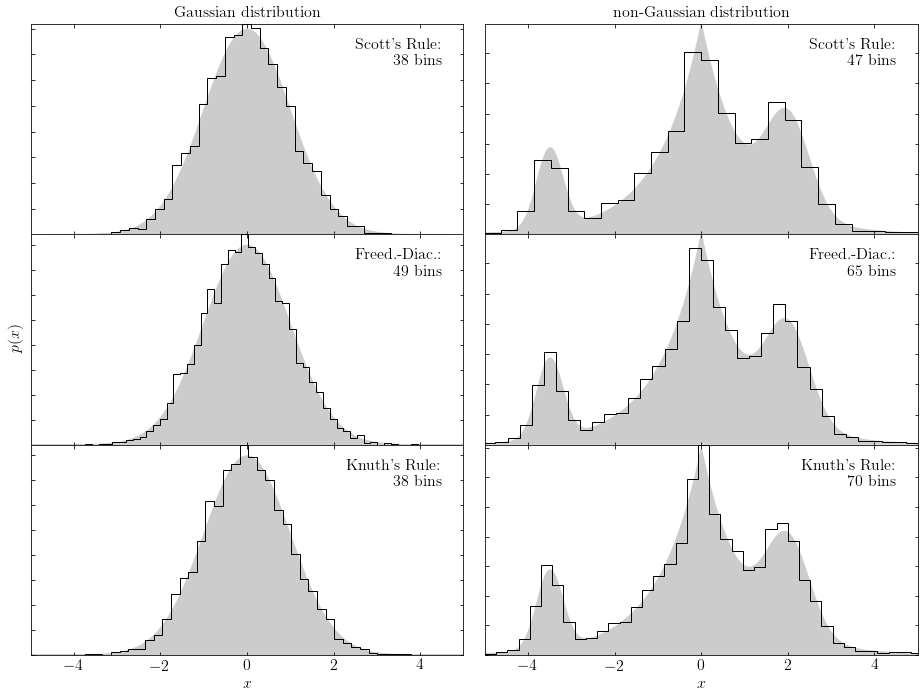

In [162]:
from astroML.plotting import hist as astroMLhist
setup_text_plots(fontsize=16, usetex=True)

def plot_labeled_histogram(style, data, name,
                           x, pdf_true, ax=None,
                           hide_x=False,
                           hide_y=False):
    if ax is not None:
        ax = plt.axes(ax)

    counts, bins, patches = astroMLhist(data, bins=style, ax=ax,
                                 color='k', histtype='step', normed=True)
    ax.text(0.95, 0.93, '%s:\n%i bins' % (name, len(counts)),
            transform=ax.transAxes,
            ha='right', va='top')

    ax.fill(x, pdf_true, '-', color='#CCCCCC', zorder=0)

    if hide_x:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    if hide_y:
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.set_xlim(-5, 5)

    return ax


#------------------------------------------------------------
# Set up distributions:
Npts = 5000
np.random.seed(0)
x = np.linspace(-6, 6, 1000)

# Gaussian distribution
data_G = stats.norm(0, 1).rvs(Npts)
pdf_G = stats.norm(0, 1).pdf(x)

# Non-Gaussian distribution
distributions = [stats.laplace(0, 1.0),
                 stats.norm(-3.5, 0.3),
                 stats.norm(2.0, 0.5)]

weights = np.array([0.7, 0.1, 0.2])
weights /= weights.sum()

data_NG = np.hstack(d.rvs(int(w * Npts))
                    for (d, w) in zip(distributions, weights))
pdf_NG = sum(w * d.pdf(x)
             for (d, w) in zip(distributions, weights))

#------------------------------------------------------------
# Plot results
fig = plt.figure(figsize=(14, 12))
fig.subplots_adjust(hspace=0, left=0.07, right=0.95, wspace=0.05, bottom=0.15)
ax = [fig.add_subplot(3, 2, i + 1) for i in range(6)]

# first column: Gaussian distribution
plot_labeled_histogram('scotts', data_G, 'Scott\'s Rule', x, pdf_G,
                       ax=ax[0], hide_x=True, hide_y=True)
plot_labeled_histogram('freedman', data_G, 'Freed.-Diac.', x, pdf_G,
                       ax=ax[2], hide_x=True, hide_y=True)
plot_labeled_histogram('knuth', data_G, 'Knuth\'s Rule', x, pdf_G,
                       ax=ax[4], hide_x=False, hide_y=True)

ax[0].set_title('Gaussian distribution')
ax[2].set_ylabel('$p(x)$')
ax[4].set_xlabel('$x$')

# second column: non-gaussian distribution
plot_labeled_histogram('scotts', data_NG, 'Scott\'s Rule', x, pdf_NG,
                       ax=ax[1], hide_x=True, hide_y=True)
plot_labeled_histogram('freedman', data_NG, 'Freed.-Diac.', x, pdf_NG,
                       ax=ax[3], hide_x=True, hide_y=True)
plot_labeled_histogram('knuth', data_NG, 'Knuth\'s Rule', x, pdf_NG,
                       ax=ax[5], hide_x=False, hide_y=True)

ax[1].set_title('non-Gaussian distribution')
ax[5].set_xlabel('$x$')

plt.show()

# Two-dimensional kernel smoothing: the “SDSS Great Wall” 

The “SDSS Great Wall” is the largest known concentration of galaxies (Gott et al. 2005, ApJ 624, 463)

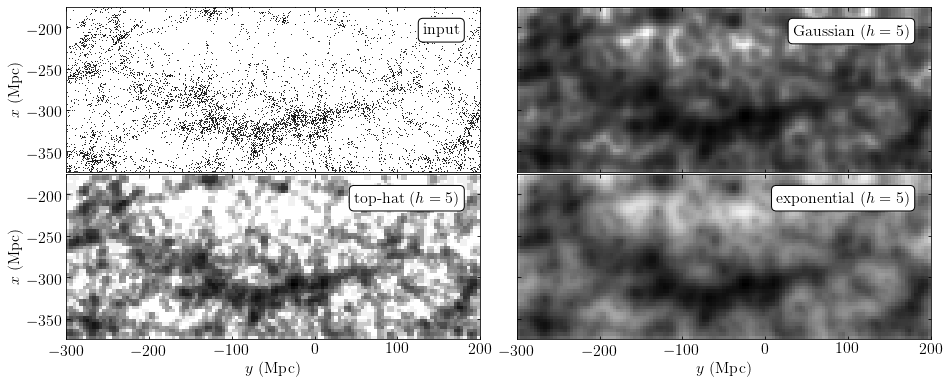

In [190]:
### Modeled after astroML book figure 6.3
### https://www.astroml.org/book_figures/chapter6/fig_great_wall_KDE.html

from matplotlib.colors import LogNorm
from sklearn.neighbors import KernelDensity
from astroML.datasets import fetch_great_wall
setup_text_plots(fontsize=16, usetex=True)

#------------------------------------------------------------
# Fetch the great wall data
X = fetch_great_wall()

#------------------------------------------------------------
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

kernels = ['gaussian', 'tophat', 'exponential']
dens = []

kde1 = KernelDensity(bandwidth=5, kernel='gaussian')
log_dens1 = kde1.fit(X).score_samples(Xgrid)
dens1 = X.shape[0] * np.exp(log_dens1).reshape((Ny, Nx))

kde2 = KernelDensity(bandwidth=5, kernel='tophat')
log_dens2 = kde2.fit(X).score_samples(Xgrid)
dens2 = X.shape[0] * np.exp(log_dens2).reshape((Ny, Nx))

kde3 = KernelDensity(bandwidth=5, kernel='exponential')
log_dens3 = kde3.fit(X).score_samples(Xgrid)
dens3 = X.shape[0] * np.exp(log_dens3).reshape((Ny, Nx))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(15, 6.6))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: gaussian kernel
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens1.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.text(0.95, 0.9, "Gaussian $(h=5)$", ha='right', va='top',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Third plot: top-hat kernel
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens2.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax3.text(0.95, 0.9, "top-hat $(h=5)$", ha='right', va='top',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))
ax3.images[0].set_clim(0.01, 0.8)

# Fourth plot: exponential kernel
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens3.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax4.text(0.95, 0.9, "exponential $(h=5)$", ha='right', va='top',
         transform=ax4.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax3, ax4]:
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax3]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()


# Bayesian Blocks

Though Knuth’s Bayesian method for choosing histogram bin width is 
an improvement over the Scott’s rule and the Freedman–Diaconis rule, 
it still has a distinct weakness: it assumes a **uniform** width for 
the optimal histogram bins.  

This limitation can be lifted by maximizing a well-designed likelihood function over bins of varying width. This approach has been dubbed Bayesian blocks. The method was first developed in the field of 
time-domain analysis by Jeff Scargle (1998, The Astrophysical Journal, Volume 504, pp. 405-418), 
but is readily applicable to histogram data as well.

### Bayesian Blocks are an extension of Knuth's histograms to variable bin width. 

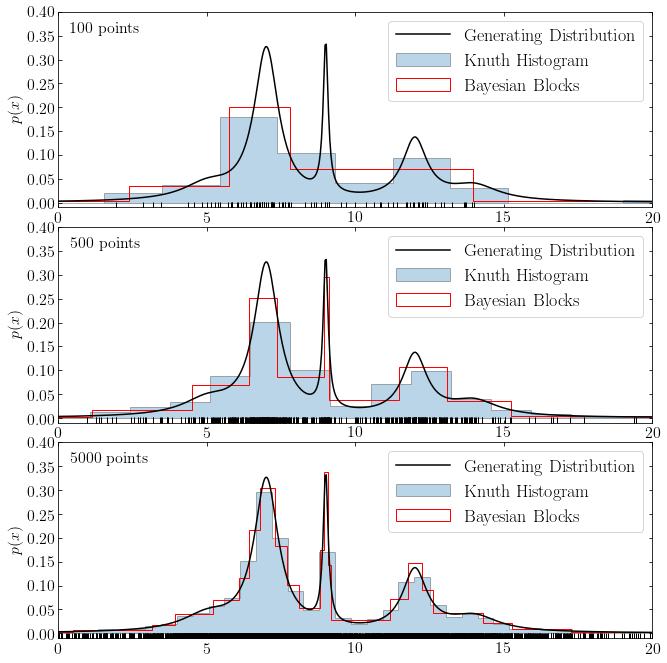

In [180]:
### Modeled after astroML book figure 5.21
### https://www.astroml.org/book_figures/chapter5/fig_bayes_blocks.html
# from astropy.visualization import hist
from astroML.plotting import hist
setup_text_plots(fontsize=16, usetex=True)

#------------------------------------------------------------
# Generate our data: a mix of several Cauchy distributions
np.random.seed(0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N))
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
N_values = (100, 500, 5000)
subplots = (311, 312, 313)

for N, subplot in zip(N_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]
    t = np.linspace(-10, 30, 1000)

    # plot the results
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k')
    hist(xN, bins='knuth', ax=ax, normed=True,  
         histtype='stepfilled', alpha=0.3,
         label='Knuth Histogram')
    hist(xN, bins='blocks', ax=ax, normed=True, 
         histtype='step', color='red',
         label="Bayesian Blocks")
    ax.plot(t, true_pdf(t), '-', color='black',
            label="Generating Distribution")

    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.set_ylabel('$p(x)$')
    ax.legend(loc='upper right', prop=dict(size=18))

    if subplot == 212:
        ax.set_xlabel('$x$')

    ax.set_xlim(0, 20)
    ax.set_ylim(-0.01, 0.4001)

plt.show()

## Conclusions

Note the superiority of Bayesian Blocks: when Ndata = 500 points, Knuth's histogram doesn't discover the middle peak (there goes his Nobel Prize...)

# Mixture Models

We frequently encounter cases where we obtain data that show certain multi-modal behavior (i.e., have "multiple peaks"). It's useful to try to see whether a ***mixture*** of simple models (typically, Gaussians) can explain the data, and how many simple models are sufficient to explain the data.

## Examples:
* Unresolved ("blended") stars that are very close together.
* Overlapping stellar streams in velocity space
* Overlapping asteroid families
* Chemical analysis in mass spectrometer
* Elementary particles in energy space
* ... many others ...

## Questions:
* What is the number of components in the mixture that best explains the data?
* What are the values of those components' parameters?

# Mixture Models: Gaussian

Mixture models use the sum of functions to represent the density distributions - used in defining the density, classifications, cloning of a data set....

Gaussian mixture models (GMMs) are the most common implementation of mixture models

## $\rho(\mathbf{x}) = N\, p(\mathbf{x})
  = N\, \sum_{j=1}^M \alpha_j \mathcal{N}(\mu_j, \Sigma_j)$
  
with  
## $p(\mathbf{x}) = \sum_j \alpha_j \mathcal{N}(\mathbf{x}|\mathbf{\mu}_{j},\mathbf{\Sigma}_{j})$

and

## $\mathcal{N}(\mathbf{x}|\mathbf{\mu}_j,\mathbf{\Sigma}_j) =
  \frac{1}{\sqrt{(2\pi)^D\mbox{det}(\mathbf{\Sigma}_j)}}
      \exp\Big(-\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^T\mathbf{\Sigma}_j^{-1}(\mathbf{x}-\mathbf{\mu})\Big)\, $



where the model consists of $M$ Gaussians with locations $\mu_j$
and covariances $\Sigma_j$. The log-likelihood is straightforward to define by this model.

<u> _Expectation maximization_ </u> is typically employed to solve for the mixture of Gaussians


## - _Expectation_

  - Given a set of Gaussians compute the “expected” classes of all points

## - _Maximization_

  - Estimate the MLE of $\mu$, amplitude, and $\Sigma$ given the data’s class membership 

Iterative proceedure until variance does not change. Guaranteed to converge - but not to the correct answer!

![SlideGrab](figures/slide-ema1.png) 

![SlideGrab](figures/slide-ema2.png) 

# The code below simulates a one-dimensional dataset with 4 Gaussian components of arbitrary size, can add measurement errors, and then fits Gaussian Mixture Models to this dataset.

In [164]:
### Modeled after astroML book figure 4.2
### https://www.astroml.org/book_figures/chapter4/fig_GMM_1D.html
from sklearn.mixture import GaussianMixture
def doGMM(Ndata, noiseStd=0.0, Nmax=10, verbose=False):
    #------------------------------------------------------------
    ## Set up the dataset
    # Ndata is the dataset size
    # noiseStd is "measurement" noise
    # Nmax is the maximum number of Gaussian components to fit
    #  We'll create our dataset by drawing samples from 4 Gaussians.
    random_state = np.random.RandomState(seed=1)
    N1 = np.int(0.2*Ndata)
    N2 = np.int(0.3*Ndata)
    N3 = np.int(0.2*Ndata)
    N4 = Ndata - (N1 + N2 + N3)
    X = np.concatenate([random_state.normal(-4.0, 1.1, N1),
                        random_state.normal(-1.0, 1.0, N2),
                         random_state.normal(0.9, 0.7, N3),
                         random_state.normal(3.5, 1.5, N4)]).reshape(-1, 1)        
    if (noiseStd >0):
        # convolution by "measurement" errors
        X = np.random.normal(X, noiseStd)
    
    #------------------------------------------------------------
    ## Learn (train) the best-fit GMM models
    # Here we'll use GMM in the standard way: the fit() method
    # uses an Expectation-Maximization approach to find the best
    # mixture of Gaussians for the data

    # fit Nmax models with the number of components increasing from 1 to Nmax 
    N = np.arange(1, Nmax+1)
    models = [None for i in range(len(N))]
    
    for i in range(len(N)):
        models[i] = GaussianMixture(N[i]).fit(X)    
    
    # compute the BIC
    BIC = [m.bic(X) for m in models]
    # compute delta(BIC) between the best model and the preceding one
    deltaBIC = BIC[np.argmin(BIC)] - BIC[np.argmin(BIC)-1]
    print("deltaBIC=",deltaBIC)

    # best model (useful for classification)
    M_best = models[np.argmin(BIC)]
    x = np.linspace(-10, 10, 1000)
    logprob = M_best.score_samples(x.reshape(-1, 1))
    responsibilities = M_best.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    #------------------------------------------------------------
    ## Plot the results
    #  We'll use two panels:
    #   1) data + best-fit mixture
    #   2) BIC vs number of components 

    fig = plt.figure(figsize=(12, 7))
    fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)

    # plot 1: data + best-fit mixture
    ax = fig.add_subplot(121)
    ax.hist(X, 'auto', normed=True, histtype='stepfilled', alpha=0.4)
    ax.plot(x, pdf, '-k')
    ax.plot(x, pdf_individual, '--k')
    ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')

    # plot 2: BIC
    ax = fig.add_subplot(122)
    ax.plot(N, BIC, '--k')
    ax.set_xlabel('n. components')
    ax.set_ylabel('BIC')

    plt.show()  
        
    if (verbose):    
        print("means:", M_best.means_)
        print("weights:", M_best.weights_)

## Let's first investigate how sample size impacts our results...

('deltaBIC=', 0.0)


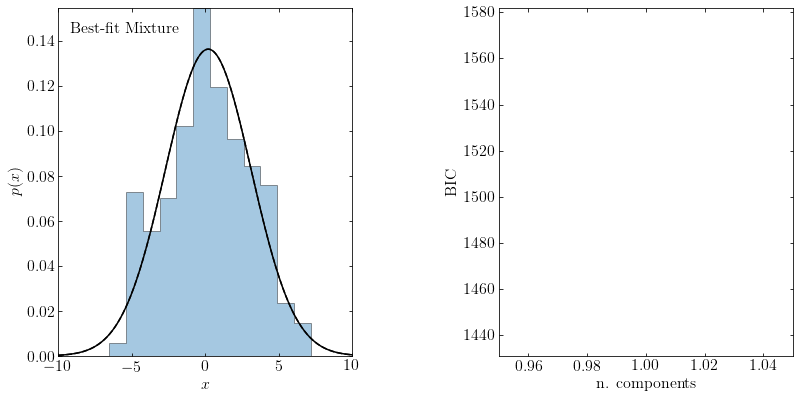

In [166]:
# 300 points, no measurement errors, only fit 1 Gaussian 
doGMM(300, 0.0, 1)

## Do you believe there are 4 components in that histogram? 

## Let's investigate how sample size impacts our results...

('deltaBIC=', -35.127924085572886)


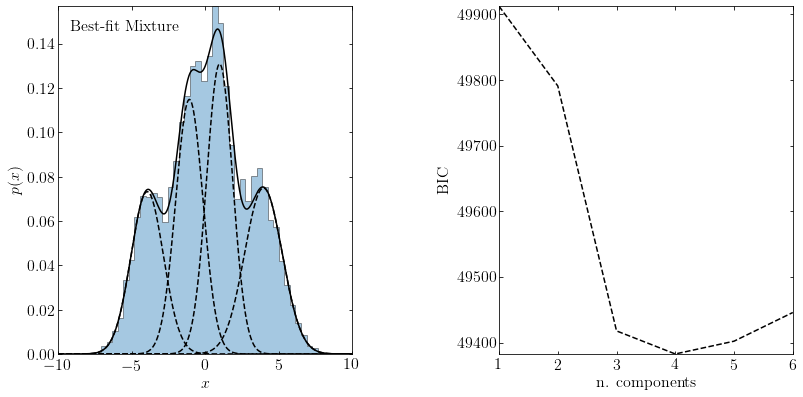

('means:', array([[ 0.97682415],
       [-3.95195382],
       [-1.08217467],
       [ 3.95764095]]))
('weights:', array([0.28979908, 0.20269578, 0.2670706 , 0.24043454]))


In [168]:
doGMM(10000, 0.0, 6, True) 

##  BIC stands for Bayesian Information Criterion. How do we interpret BIC? 

The figure above (right panel) shows that the 4-component model has a BIC lower
by about 40 than the 3-component model. Is this sufficient evidence to claim that 
we really see 4 components and not 3? 

**How do we interpret the values of the odds ratio in practice? **
Jeffreys proposed a five-step scale for interpreting the odds ratio, where $O_{21} > 10$ represents “strong” evidence in favor of $M_2$ ($M_2$ is ten times more probable than $M_1$), and $O_{21} > 100$ is “decisive” evidence ($M_2$ is one hundred times more probable than $M_1$). When $O_{21} < 3$, the evidence is “not worth more than a bare mention.”

##  How do we interpret BIC? 
 
Given the relationship between the BIC and $O_{21},$ 
$$    \Delta BIC \equiv BIC_2 - BIC_1 = -2\,\ln(O_{21}) $$ 
we have that $O_{21}=10$ corresponds to $\Delta BIC= -4.6$ and $O_{21}=100$ corresponds to $\Delta BIC = -9.2$.
For completeness, $|\Delta BIC|<2$ is “not worth more than a bare mention.”

Therefore, ** $|\Delta BIC| = 5$ corresponds to “strong” evidence and $|\Delta BIC| = 10$ to “decisive” evidence.**

We can conclude that the figure above (for 10,000 points) shows **decisive** evidence in favor of the 4-component model. That is,
you should **not** argue that there are 3 peaks, or 5 peaks, in the left panel! 

('deltaBIC=', -759.0354466498247)


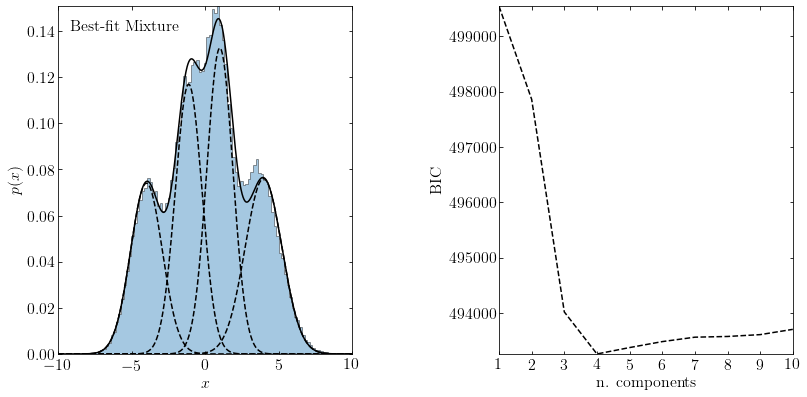

In [169]:
doGMM(100000) 

('deltaBIC=', -8130.768863534555)


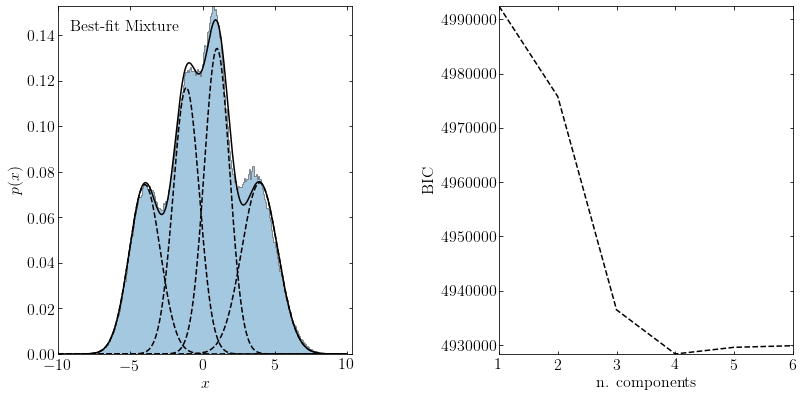

('means:', array([[-4.00282532],
       [ 0.99863141],
       [-1.1268427 ],
       [ 3.9681313 ]]))
('weights:', array([0.20121755, 0.29648649, 0.26562015, 0.23667581]))


In [170]:
doGMM(1000000, 0.0, 6, True)

#  What if we decrease the sample size? 

('deltaBIC=', -70.2611857763277)


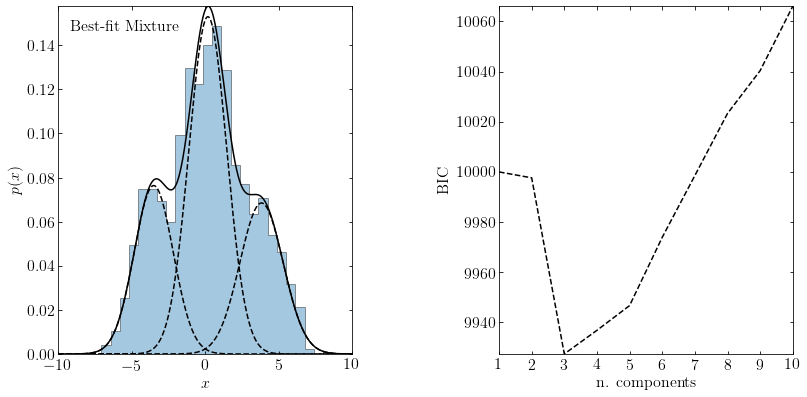

In [171]:
doGMM(2000)

##  How do we interpret BIC? 
Altough we **did** draw that dataset from a model with 4 components, a sample of 2000 values is insufficient to *discover* more than 3 components! 

('deltaBIC=', -116.86055878316938)


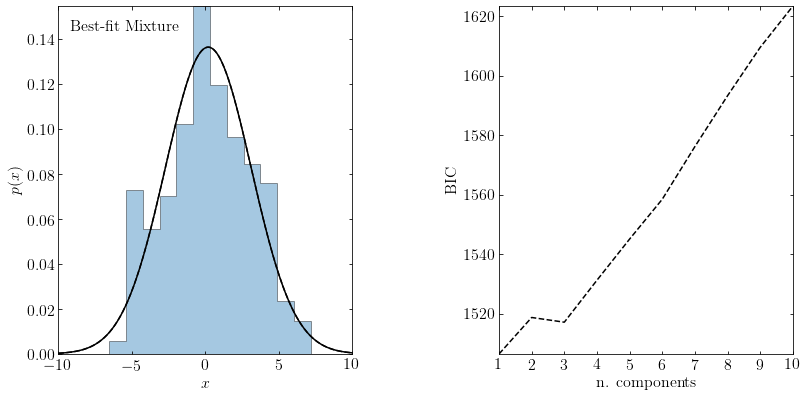

In [172]:
doGMM(300) 

('deltaBIC=', -8.092503990865225)


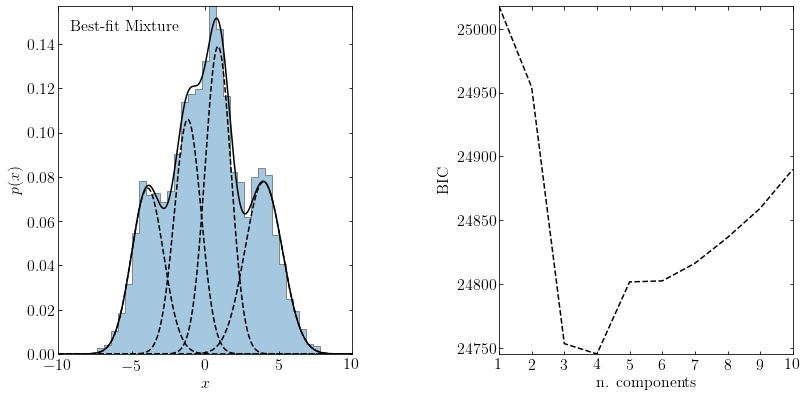

In [173]:
doGMM(5000)

**Conclusion** Large sample size helps! I love surveys, I love LSST! 

But one more thing: let's convolve our data with an arbitrary Gaussian 
to simulate measurement errors. 

('deltaBIC=', -62.83900587035532)


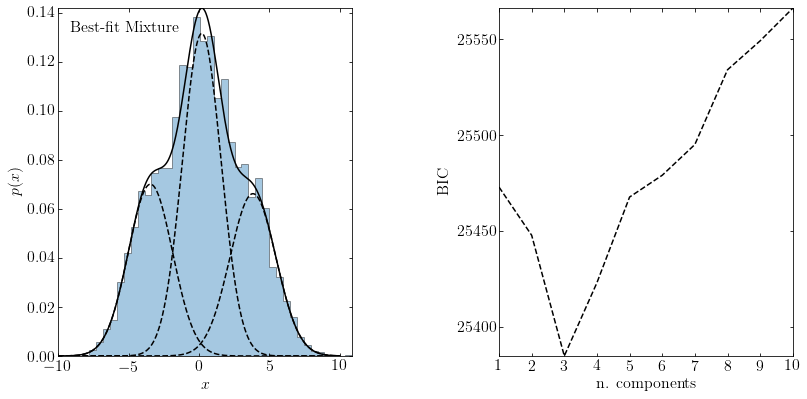

In [174]:
doGMM(5000,1.0)

('deltaBIC=', -233.60599501171237)


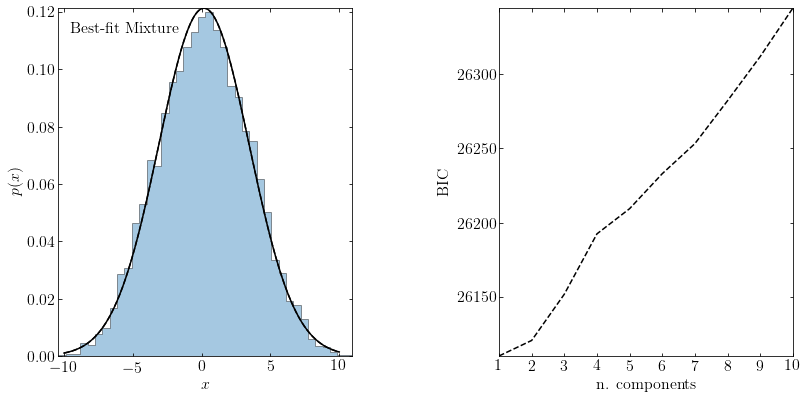

In [175]:
doGMM(5000,1.5)

**Conclusion** Duh! If you badly "blur" your sample, of course you will not see the fine
structure (i.e. many components)! 

Therefore, even with large samples, you still need to have precise and well calibrated 
measurements! Another reason to love LSST! 
 

## Multi-dimensional example

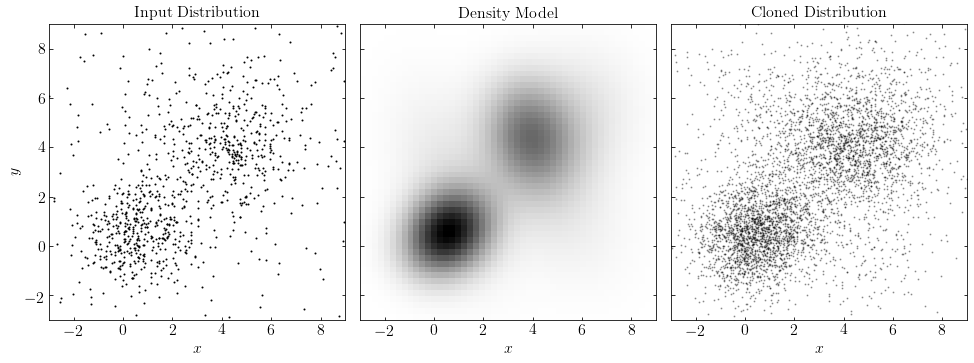

In [176]:
### Modeled after astroML book figure 6.10: 
### https://www.astroml.org/book_figures/chapter6/fig_GMM_clone.html
from sklearn.mixture import GaussianMixture

#------------------------------------------------------------
# Create our data: two overlapping gaussian clumps,
# in a uniform background
np.random.seed(1)
X = np.concatenate([np.random.normal(0, 1, (200, 2)),
                    np.random.normal(1, 1, (200, 2)),
                    np.random.normal(4, 1.5, (400, 2)),
                    9 - 12 * np.random.random((200, 2))])

#------------------------------------------------------------
# Use a GaussianMixture to model the density and clone the points
gmm = GaussianMixture(5, 'full').fit(X)
X_new = gmm.sample(5000)[0]

xmin = -3
xmax = 9
Xgrid = np.meshgrid(np.linspace(xmin, xmax, 50),
                    np.linspace(xmin, xmax, 50))
Xgrid = np.array(Xgrid).reshape(2, -1).T

dens = np.exp(gmm.score_samples(Xgrid)).reshape((50, 50))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(15, 6))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.05,
                    bottom=0.12, top=0.9)

# first plot the input
ax = fig.add_subplot(131, aspect='equal')
ax.plot(X[:, 0], X[:, 1], '.k', ms=2)

ax.set_title("Input Distribution")
ax.set_ylabel('$y$')

# next plot the gmm fit
ax = fig.add_subplot(132, aspect='equal')
ax.imshow(dens.T, origin='lower', extent=[xmin, xmax, xmin, xmax],
          cmap=plt.cm.binary)

ax.set_title("Density Model")
ax.yaxis.set_major_formatter(plt.NullFormatter())

# next plot the cloned distribution
ax = fig.add_subplot(133, aspect='equal')
ax.plot(X_new[:, 0], X_new[:, 1], '.k', alpha=0.3, ms=2)

ax.set_title("Cloned Distribution")
ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in fig.axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)
    ax.set_xlabel('$x$')

plt.show()

## Extreme Deconvolution

### A.k.a. Gaussian Mixture Models with Errors

The previous examples assumed that uncertainty in data values (x) was negligible.
What do we do when this is not the case?

For example, in case of homescedastic Gaussian measurement errors, the GMM 
components would be broadened (the measurement error would be added in
quadrature to their intrinsic widths).

A recently introduced application of GMM with errors in astronomical context 
was dubbed “Extreme Deconvolution” (see Bovy et al. 2009,ArXiv:0905.2979)

### Two basic assumptions:
a) the sampled population distribution is a arbitrary mixture of high-D Gaussian components, and

b) data have heteroscedastic errors with known covariance matrix

### Extreme Deconvolution works in multi-dimensional spaces too, and naturally  treats noisy, heterogeneous, and incomplete data.


@pickle_results: using precomputed results from 'XD_toy.pkl'


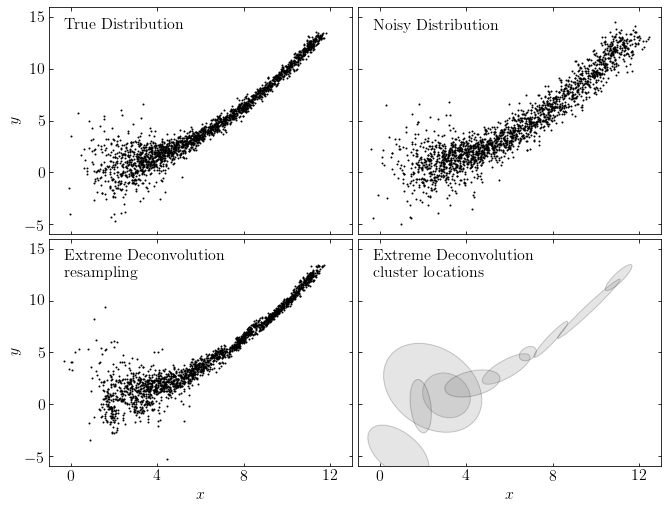

In [182]:
### SLOW AS MOLASSES! 
### Modeled after astroML book figure 6.11: 
### https://www.astroml.org/book_figures/chapter6/fig_XD_example.html
from astroML.utils.decorators import pickle_results
from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse
setup_text_plots(fontsize=16, usetex=True)

#------------------------------------------------------------
# Sample the dataset
N = 2000
np.random.seed(0)

# generate the true data
x_true = (1.4 + 2 * np.random.random(N)) ** 2
y_true = 0.1 * x_true ** 2

# add scatter to "true" distribution
dx = 0.1 + 4. / x_true ** 2
dy = 0.1 + 10. / x_true ** 2

x_true += np.random.normal(0, dx, N)
y_true += np.random.normal(0, dy, N)

# add noise to get the "observed" distribution
dx = 0.2 + 0.5 * np.random.random(N)
dy = 0.2 + 0.5 * np.random.random(N)

x = x_true + np.random.normal(0, dx)
y = y_true + np.random.normal(0, dy)

# stack the results for computation
X = np.vstack([x, y]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([dx ** 2, dy ** 2]).T


#------------------------------------------------------------
# compute and save results
@pickle_results("XD_toy.pkl")
def compute_XD_results(n_components=10, max_iter=500):
    clf = XDGMM(n_components, max_iter=max_iter)
    clf.fit(X, Xerr)
    return clf


clf = compute_XD_results(10, 500)
sample = clf.sample(N)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 7.5))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(221)
ax1.scatter(x_true, y_true, s=4, lw=0, c='k')

ax2 = fig.add_subplot(222)
ax2.scatter(x, y, s=4, lw=0, c='k')

ax3 = fig.add_subplot(223)
ax3.scatter(sample[:, 0], sample[:, 1], s=4, lw=0, c='k')

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i], clf.V[i], scales=[2], ax=ax4,
                 ec='k', fc='gray', alpha=0.2)

titles = ["True Distribution", "Noisy Distribution",
          "Extreme Deconvolution\n  resampling",
          "Extreme Deconvolution\n  cluster locations"]

ax = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax[i].set_xlim(-1, 13)
    ax[i].set_ylim(-6, 16)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(4))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$x$')

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$y$')

plt.show()

@pickle_results: computing results and saving to 'XD_toy2.pkl'


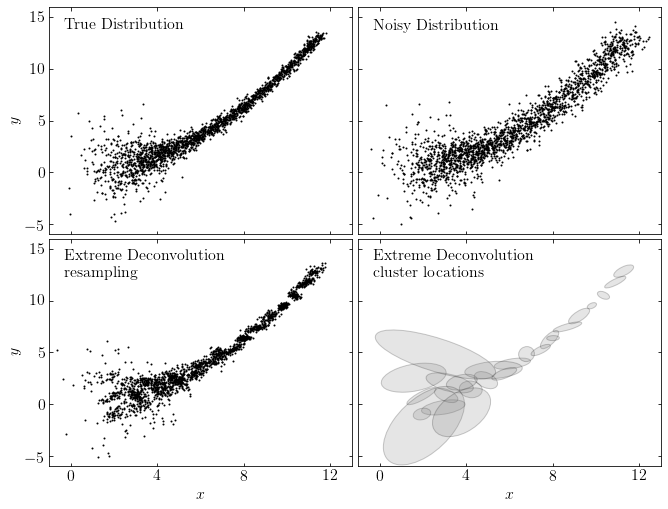

In [184]:
### SLOW AS MOLASSES! 
### Modeled after astroML book figure 6.11: 
### https://www.astroml.org/book_figures/chapter6/fig_XD_example.html
from astroML.utils.decorators import pickle_results
from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse
setup_text_plots(fontsize=16, usetex=True)

#------------------------------------------------------------
# Sample the dataset
N = 2000
np.random.seed(0)

# generate the true data
x_true = (1.4 + 2 * np.random.random(N)) ** 2
y_true = 0.1 * x_true ** 2

# add scatter to "true" distribution
dx = 0.1 + 4. / x_true ** 2
dy = 0.1 + 10. / x_true ** 2

x_true += np.random.normal(0, dx, N)
y_true += np.random.normal(0, dy, N)

# add noise to get the "observed" distribution
dx = 0.2 + 0.5 * np.random.random(N)
dy = 0.2 + 0.5 * np.random.random(N)

x = x_true + np.random.normal(0, dx)
y = y_true + np.random.normal(0, dy)

# stack the results for computation
X = np.vstack([x, y]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([dx ** 2, dy ** 2]).T


#------------------------------------------------------------
# compute and save results
@pickle_results("XD_toy2.pkl")
def compute_XD_results(n_components=10, max_iter=500):
    clf = XDGMM(n_components, max_iter=max_iter)
    clf.fit(X, Xerr)
    return clf


clf = compute_XD_results(25, 100)
sample = clf.sample(N)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 7.5))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(221)
ax1.scatter(x_true, y_true, s=4, lw=0, c='k')

ax2 = fig.add_subplot(222)
ax2.scatter(x, y, s=4, lw=0, c='k')

ax3 = fig.add_subplot(223)
ax3.scatter(sample[:, 0], sample[:, 1], s=4, lw=0, c='k')

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i], clf.V[i], scales=[2], ax=ax4,
                 ec='k', fc='gray', alpha=0.2)

titles = ["True Distribution", "Noisy Distribution",
          "Extreme Deconvolution\n  resampling",
          "Extreme Deconvolution\n  cluster locations"]

ax = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax[i].set_xlim(-1, 13)
    ax[i].set_ylim(-6, 16)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(4))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$x$')

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$y$')

plt.show()

## Extreme Deconvolution: SDSS stellar photometry

![slide](figures/slide_ed.png)

number of noisy points:   (82003, 2)
number of stacked points: (13377, 2)
size after crossmatch: (12313, 5)
@pickle_results: using precomputed results from 'XD_stellar.pkl'


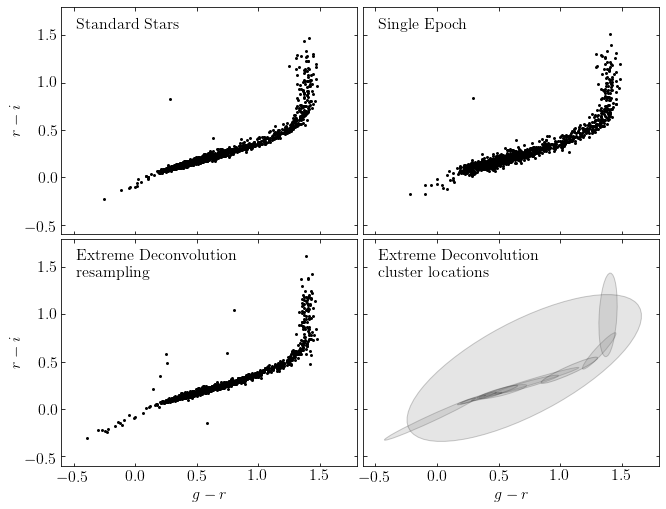

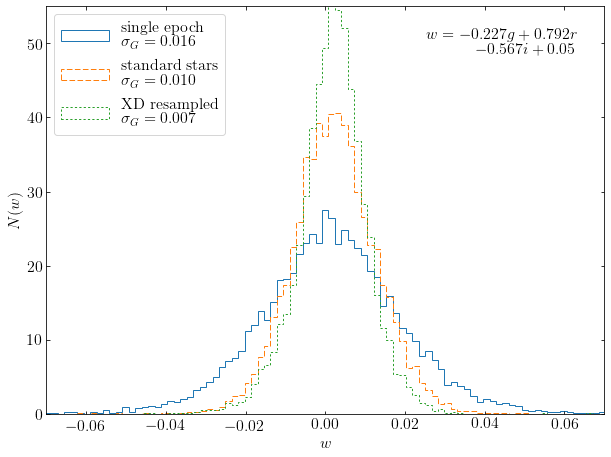

In [188]:
### Modeled after astroML book figure 6.12: 
### https://www.astroml.org/book_figures/chapter6/fig_stellar_XD.html 
from __future__ import print_function, division
from astroML.density_estimation import XDGMM
from astroML.crossmatch import crossmatch
from astroML.datasets import fetch_sdss_S82standards, fetch_imaging_sample
from astroML.plotting.tools import draw_ellipse
from astroML.utils.decorators import pickle_results
from astroML.stats import sigmaG
setup_text_plots(fontsize=16, usetex=True)

#------------------------------------------------------------
# define u-g-r-i-z extinction from Berry et al, arXiv 1111.4985
# multiply extinction by A_r
extinction_vector = np.array([1.810, 1.400, 1.0, 0.759, 0.561])

#----------------------------------------------------------------------
# Fetch and process the noisy imaging data
data_noisy = fetch_imaging_sample()

# select only stars
data_noisy = data_noisy[data_noisy['type'] == 6]

# Get the extinction-corrected magnitudes for each band
X = np.vstack([data_noisy[f + 'RawPSF'] for f in 'ugriz']).T
Xerr = np.vstack([data_noisy[f + 'psfErr'] for f in 'ugriz']).T

# extinction terms from Berry et al, arXiv 1111.4985
X -= (extinction_vector * data_noisy['rExtSFD'][:, None])


#----------------------------------------------------------------------
# Fetch and process the stacked imaging data
data_stacked = fetch_sdss_S82standards()

# cut to RA, DEC range of imaging sample
RA = data_stacked['RA']
DEC = data_stacked['DEC']
data_stacked = data_stacked[(RA > 0) & (RA < 10) &
                            (DEC > -1) & (DEC < 1)]

# get stacked magnitudes for each band
Y = np.vstack([data_stacked['mmu_' + f] for f in 'ugriz']).T
Yerr = np.vstack([data_stacked['msig_' + f] for f in 'ugriz']).T

# extinction terms from Berry et al, arXiv 1111.4985
Y -= (extinction_vector * data_stacked['A_r'][:, None])

# quality cuts
g = Y[:, 1]
mask = ((Yerr.max(1) < 0.05) &
        (g < 20))
data_stacked = data_stacked[mask]
Y = Y[mask]
Yerr = Yerr[mask]


#----------------------------------------------------------------------
# cross-match
#  the imaging sample contains both standard and variable stars.  We'll
#  perform a cross-match with the standard star catalog and choose objects
#  which are common to both.
Xlocs = np.hstack((data_noisy['ra'][:, np.newaxis],
                   data_noisy['dec'][:, np.newaxis]))
Ylocs = np.hstack((data_stacked['RA'][:, np.newaxis],
                   data_stacked['DEC'][:, np.newaxis]))

print("number of noisy points:  ", Xlocs.shape)
print("number of stacked points:", Ylocs.shape)

# find all points within 0.9 arcsec.  This cutoff was selected
# by plotting a histogram of the log(distances).
dist, ind = crossmatch(Xlocs, Ylocs, max_distance=0.9 / 3600)

noisy_mask = (~np.isinf(dist))
stacked_mask = ind[noisy_mask]

# select the data
data_noisy = data_noisy[noisy_mask]
X = X[noisy_mask]
Xerr = Xerr[noisy_mask]

data_stacked = data_stacked[stacked_mask]
Y = Y[stacked_mask]
Yerr = Yerr[stacked_mask]

# double-check that our cross-match succeeded
assert X.shape == Y.shape
print("size after crossmatch:", X.shape)


#----------------------------------------------------------------------
# perform extreme deconvolution on the noisy sample

# first define mixing matrix W
W = np.array([[0, 1, 0, 0, 0],    # g magnitude
              [1, -1, 0, 0, 0],   # u-g color
              [0, 1, -1, 0, 0],   # g-r color
              [0, 0, 1, -1, 0],   # r-i color
              [0, 0, 0, 1, -1]])  # i-z color

X = np.dot(X, W.T)
Y = np.dot(Y, W.T)

# compute error covariance from mixing matrix
Xcov = np.zeros(Xerr.shape + Xerr.shape[-1:])
Xcov[:, range(Xerr.shape[1]), range(Xerr.shape[1])] = Xerr ** 2

# each covariance C = WCW^T
# best way to do this is with a tensor dot-product
Xcov = np.tensordot(np.dot(Xcov, W.T), W, (-2, -1))


#----------------------------------------------------------------------
# This is a long calculation: save results to file
@pickle_results("XD_stellar.pkl")
def compute_XD(n_clusters=12, rseed=0, max_iter=100, verbose=True):
    np.random.seed(rseed)
    clf = XDGMM(n_clusters, max_iter=max_iter, tol=1E-5, verbose=verbose)
    clf.fit(X, Xcov)
    return clf


clf = compute_XD(12)

#------------------------------------------------------------
# Fit and sample from the underlying distribution
np.random.seed(42)
X_sample = clf.sample(X.shape[0])

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 7.5))
fig.subplots_adjust(left=0.12, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

# only plot 1/10 of the stars for clarity
ax1 = fig.add_subplot(221)
ax1.scatter(Y[::10, 2], Y[::10, 3], s=9, lw=0, c='k')

ax2 = fig.add_subplot(222)
ax2.scatter(X[::10, 2], X[::10, 3], s=9, lw=0, c='k')

ax3 = fig.add_subplot(223)
ax3.scatter(X_sample[::10, 2], X_sample[::10, 3], s=9, lw=0, c='k')

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i, 2:4], clf.V[i, 2:4, 2:4], scales=[2],
                 ec='k', fc='gray', alpha=0.2, ax=ax4)

titles = ["Standard Stars", "Single Epoch",
          "Extreme Deconvolution\n  resampling",
          "Extreme Deconvolution\n  cluster locations"]
ax = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax[i].set_xlim(-0.6, 1.8)
    ax[i].set_ylim(-0.6, 1.8)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(0.5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$g-r$')

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$r-i$')

#------------------------------------------------------------
# Second figure: the width of the locus
fig = plt.figure(figsize=(10, 7.5))
ax = fig.add_subplot(111)

labels = ['single epoch', 'standard stars', 'XD resampled']
linestyles = ['solid', 'dashed', 'dotted']
for data, label, ls in zip((X, Y, X_sample), labels, linestyles):
    g = data[:, 0]
    gr = data[:, 2]
    ri = data[:, 3]

    r = g - gr
    i = r - ri

    mask = (gr > 0.3) & (gr < 1.0)
    g = g[mask]
    r = r[mask]
    i = i[mask]

    w = -0.227 * g + 0.792 * r - 0.567 * i + 0.05

    sigma = sigmaG(w)

    ax.hist(w, bins=np.linspace(-0.08, 0.08, 100), linestyle=ls,
            histtype='step', label=label + '\n\t' + r'$\sigma_G=%.3f$' % sigma,
            normed=True)

ax.legend(loc=2)
ax.text(0.95, 0.95, '$w = -0.227g + 0.792r$\n$ - 0.567i + 0.05$',
        transform=ax.transAxes, ha='right', va='top')

ax.set_xlim(-0.07, 0.07)
ax.set_ylim(0, 55)

ax.set_xlabel('$w$')
ax.set_ylabel('$N(w)$')

plt.show()